In [1]:
import pandas as pd

#gta = pd.read_csv('C:\\Users\\admin\\Documents\\GTA_Plots\\GTA_reduceData.csv', header=-1, dtype={"time": DatetimeIndex, "idsession": int, "scenario" : int, "speed" : float, "nextpedestrianrunning" : int, "nextpedestrianid" : int})

#steering = pd.read_csv('C:\\Users\\admin\\Documents\\GTA_Plots\\steeringData.csv', header=-1)
import psycopg2


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

In [3]:
# Define our connection string
conn_string = "host='localhost' port='5432' dbname='GTA' user='postgres'"

# print the connection string we will use to connect
print ("Connecting to database\n	->")

# get a connection, if a connect cannot be made an exception will be raised here
conn = psycopg2.connect(conn_string)

# conn.cursor will return a cursor object, you can use this cursor to perform queries
cursor = conn.cursor()
print( "Connected!\n" )

#cursor.execute('SELECT * FROM  public."GTA_DataView";')

Connecting to database
	->
Connected!



In [4]:
cursor.execute('SELECT time, idsession, scenario,' +
               ' SUM(CASE data_type_id WHEN 1 THEN value ELSE 0 END) as posX,' +
               'SUM(CASE data_type_id WHEN 2 THEN value ELSE 0 END) as posY,' +
               ' SUM(CASE data_type_id WHEN 10 THEN value ELSE 0 END) as hadCollision,'+
               ' SUM(CASE data_type_id WHEN 17 THEN value ELSE 0 END) as pedId,'+
               ' SUM(CASE data_type_id WHEN 15 THEN value ELSE 0 END) as nextPedRunning,'+
               ' SUM(CASE data_type_id WHEN 11 THEN value ELSE 0 END) as distancePed,'+
                ' SUM(CASE data_type_id WHEN 8 THEN value ELSE 0 END) as speed,'+
                ' SUM(CASE data_type_id WHEN 12 THEN value ELSE 0 END) as posPedX,'+
                ' SUM(CASE data_type_id WHEN 13 THEN value ELSE 0 END) as posPedY,'+
               ' SUM(CASE data_type_id WHEN 596 THEN value ELSE 0 END) as currentDistance'+
               ' FROM datagta gta WHERE gta.idsession >= 144 AND gta.data_type_id in (1,2,8,10,11,12,13,15,17,596)'+
               ' AND gta.idsession not in (145,146,147,148,149,151,155,158,162,164)'+
               ' GROUP BY time, idsession, scenario;')
rows = cursor.fetchall()
timestamps = [row[0] for row in rows]
if (len(timestamps) == 0):
    print ("Something went wrong")
firstTime = timestamps[:1][0]
lastTime = timestamps[-1:][0]
dfGTA = pd.DataFrame(rows, index=timestamps)
#dfDiffGTA = dfGTA.diff()
dfGTA.columns=['time','session_id','scenario', 'Pos_X', 'Pos_Y', 'hadCollision', 'pedId', 'nextPedRunning', 'distancePed','speed', 'posPedX', 'posPedY' , 'currentDistance']
#dfGTA

print ("Abstract \n Distractions and inattentions are very important in order to reduce the road accidents. Is difficult to recognize while the driver is driving a vehicle because you can only have access to a few particular data. In this experiment we used almost the same data that we can collected in a normal car (e.g. throttle, brake, steering, etc.) and immerse the driver in different environments trying to be attentive and respecting all the traffic rules, while we can see how react this driver to the changes we purpose in the virtual simulation. Since the real reaction time of a driver involved in an accident will always be unknown to reconstruction experts, we decided to make our personal virtual environment where we test the driver's attention, and have the results from our virtual accidents so we can find the possibles causes to it with the same data we can have in a real situation.")


Abstract 
 Distractions and inattentions are very important in order to reduce the road accidents. Is difficult to recognize while the driver is driving a vehicle because you can only have access to a few particular data. In this experiment we used almost the same data that we can collected in a normal car (e.g. throttle, brake, steering, etc.) and immerse the driver in different environments trying to be attentive and respecting all the traffic rules, while we can see how react this driver to the changes we purpose in the virtual simulation. Since the real reaction time of a driver involved in an accident will always be unknown to reconstruction experts, we decided to make our personal virtual environment where we test the driver's attention, and have the results from our virtual accidents so we can find the possibles causes to it with the same data we can have in a real situation.


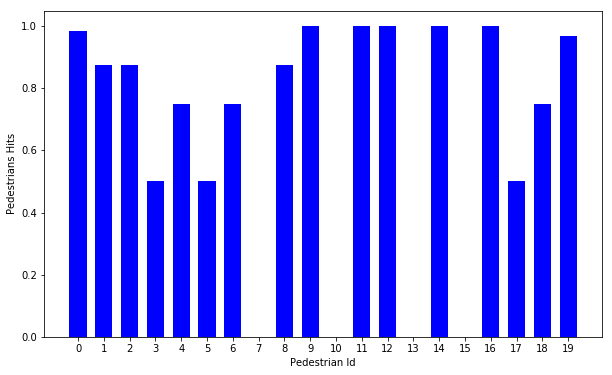

Plot with the rate of collisions that have each pedestrian. Every pedestrians appears at least in one scenario or more, because of that we put it with a rate to be able to compare. 
 Still have to update with the new algorithm to detect crashes (later explain)


In [5]:
data = dfGTA[(dfGTA.distancePed < 7) & (dfGTA.hadCollision == True) & (dfGTA.scenario != 7) & (dfGTA.scenario != 8)]
data = data.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
data = data.groupby(['session_id', 'scenario', 'pedId']).agg(['count'])
pedsHit = []
for row in data.iterrows():
    session, scenario, ped = row[0]
    pedsHit.append((session, scenario, ped))
    #if (ped == 8):
        #print (row[0])
    
countHits = {}
countHits[10] = 0
countHits[7] = 0
countHits[13] = 0
countHits[15] = 0
ratePerPed = [2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 3, 2, 2]
for tupla in pedsHit:
    countHits[tupla[2]] = float(countHits.get(tupla[2], 0) + 1)/ratePerPed[int(tupla[2])]
    
lists = sorted(countHits.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(10, 6))
plt.ylabel("Pedestrians Hits")
plt.xlabel("Pedestrian Id")
plt.xticks(range(0,20), range(0,20))
plt.bar(range(0,20), y ,1/1.5, color="blue")
#plt.savefig('PedestriansHitsRate.pdf')
plt.show()
#data
print ("Plot with the rate of collisions that have each pedestrian. Every pedestrians appears at least in one scenario or more, because of that we put it with a rate to be able to compare. \n Still have to update with the new algorithm to detect crashes (later explain)")

The number of collision per each session we have. 
 Still have to update with the new algorithm to detect crashes (later explain)


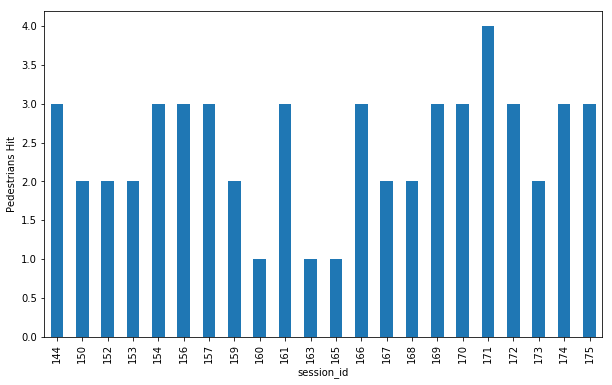

In [6]:
data = dfGTA[(dfGTA.distancePed < 7) & (dfGTA.hadCollision == True) & (dfGTA.scenario != 7) & (dfGTA.scenario != 8)]
#dataSessions = data.groupby(['session_id']).agg(['count'])
dataSessions = data.groupby(['session_id']).agg({"pedId": pd.Series.nunique, "hadCollision": 'count'})
#plt.

#dataSessions
#data['session_id'].drop_duplicates()
#data['session_id'].drop_duplicates()
plt.figure(figsize=(10, 6))
plt.ylabel("Pedestrians Hit")
plt.xlabel("Sessions")
#plt.savefig('PedestriansHitPerSession.pdf')
#dataSessions['pedId']['count'].plot.bar()
dataSessions['pedId'].plot.bar()
#plot = plt.bar(data['session_id'].drop_duplicates() ,dataSessions['hadCollision']['count'], 1/1.5, color="blue")
#plt.xticks(scenarios, labels)

#plt.savefig('PedestriansHitsPerSession.pdf')
#plt.show()

print ("The number of collision per each session we have. \n Still have to update with the new algorithm to detect crashes (later explain)")

The rate of collisions per each scenario (every scenario has different number of pedestrians). 
 Still have to update with the new algorithm to detect crashes (later explain)


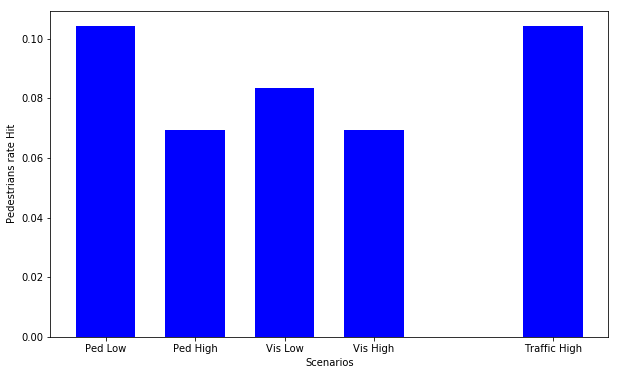

In [7]:
data = dfGTA[(dfGTA.distancePed < 7) & (dfGTA.hadCollision == True) & (dfGTA.scenario != 7) & (dfGTA.scenario != 8)]
dataSessions = data.groupby(['scenario']).agg({"pedId": pd.Series.nunique})
#print dataSessions
labels = ["Ped Low","Ped High","Vis Low","Vis High","Traffic High"]
scenarios = [1,2,3,4,6]
rateHit = [10.0/(24*4), 20.0/(24*12) ,12.0/(24*6) ,10.0/(24*6) ,15.0/(24*6)]
plt.figure(figsize=(10, 6))
plt.ylabel("Pedestrians rate Hit")
plt.xlabel("Scenarios")
plt.xticks(scenarios, labels)

plt.bar(scenarios, rateHit ,1/1.5, color="blue")

#plt.savefig('PedestriansHitRatePerScenario.pdf')

print ("The rate of collisions per each scenario (every scenario has different number of pedestrians). \n Still have to update with the new algorithm to detect crashes (later explain)")

In [8]:
cursor.execute('SELECT time, idsession, scenario,' +
               ' SUM(CASE data_type_id WHEN 1 THEN value ELSE 0 END) as Steering,' +
               'SUM(CASE data_type_id WHEN 2 THEN value ELSE 0 END) as Brake,' +
               ' SUM(CASE data_type_id WHEN 3 THEN value ELSE 0 END) as Throttle '+
               ' FROM datasteering gta WHERE gta.idsession >= 144 AND gta.data_type_id in (1,2,3)'+
               ' AND gta.idsession not in (145,146,147,148,149,151,155,158,162,164) '+
               ' GROUP BY time, idsession, scenario;')
rows = cursor.fetchall()
timestamps = [row[0] for row in rows]
df_steer = pd.DataFrame(rows, index=timestamps)
df_steer.columns=['time','session_id','scenario', 'steering', 'brake',  'throttle']
freq_resample = '50000U'
df_steer = df_steer.resample(freq_resample).ffill()
freq_resample = '50000U'
dfGTA = dfGTA.resample(freq_resample).ffill()
steer = df_steer.drop(df_steer.columns[[1, 2]], axis=1)
df_joined = pd.concat([dfGTA, steer], axis=1, join='inner')

In [9]:
#(144.0, 6.0, 8.0)
#(152.0, 3.0, 8.0)
#(172.0, 6.0, 8.0)

session2Scenario2 = df_joined[(df_joined.session_id == 144) & (df_joined.scenario == 6.0) & (df_joined.pedId == 8.0)]
session3Scenario2 = df_joined[(df_joined.session_id == 152.0) & (df_joined.scenario == 6.0) & (df_joined.pedId == 8.0)]
session1Scenario2 = df_joined[(df_joined.session_id == 172.0) & (df_joined.scenario == 6.0) & (df_joined.pedId == 8.0)]

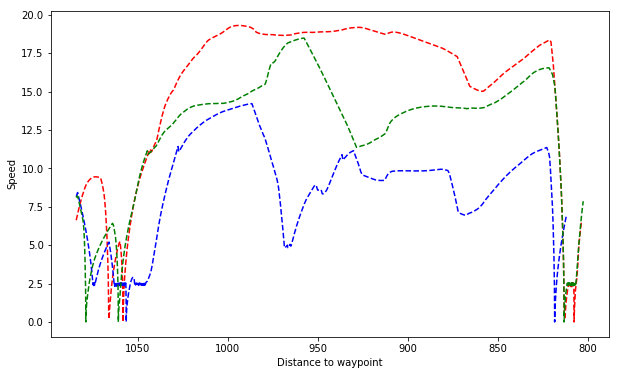

The idea is to see differences between drivers when they are involve in a complicated situation. The aim is to can cluster this differents subtypes of drivers and see real differences in his way of behaviour. One example can be the differences between the normal speed


In [10]:
plt.figure(figsize=(10, 6))
plt.plot(session2Scenario2.currentDistance, session2Scenario2.speed, 'r--', session3Scenario2.currentDistance, session3Scenario2.speed, 'b--', session1Scenario2.currentDistance, session1Scenario2.speed, 'g--')
plt.ylabel("Speed")
plt.xlabel("Distance to waypoint")
plt.gca().invert_xaxis()
#plt.savefig('speed_distance.pdf')
plt.show()

print ("The idea is to see differences between drivers when they are involve in a complicated situation. The aim is to can cluster this differents subtypes of drivers and see real differences in his way of behaviour. One example can be the differences between the normal speed")

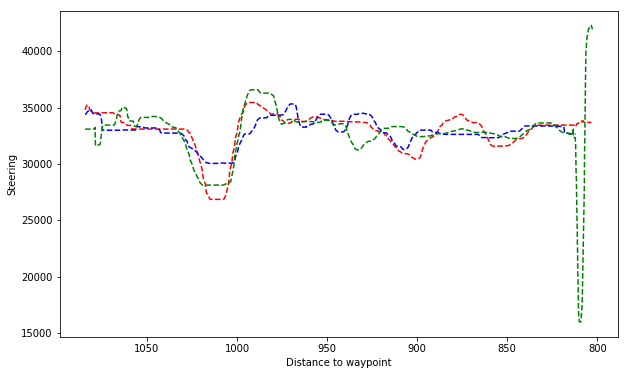

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(session2Scenario2.currentDistance, session2Scenario2.steering, 'r--', session3Scenario2.currentDistance, session3Scenario2.steering, 'b--', session1Scenario2.currentDistance, session1Scenario2.steering, 'g--')
plt.ylabel("Steering")
plt.xlabel("Distance to waypoint")
plt.gca().invert_xaxis()
#plt.savefig('steering_distance.pdf')
plt.show()

In [12]:
scenario = 6
ped = 8
zoom2 = df_joined[(df_joined.session_id == 144) & (df_joined.scenario == scenario) & (df_joined.pedId == ped) & (df_joined.nextPedRunning == True) & (dfGTA.distancePed < 10) ]
zoom3 = df_joined[(df_joined.session_id == 152.0) & (df_joined.scenario == scenario) & (df_joined.pedId == ped) & (df_joined.nextPedRunning == True) & (dfGTA.distancePed < 10) ]
zoom1 = df_joined[(df_joined.session_id == 172.0) & (df_joined.scenario == scenario) & (df_joined.pedId == ped) & (df_joined.nextPedRunning == True) & (dfGTA.distancePed < 10) ]

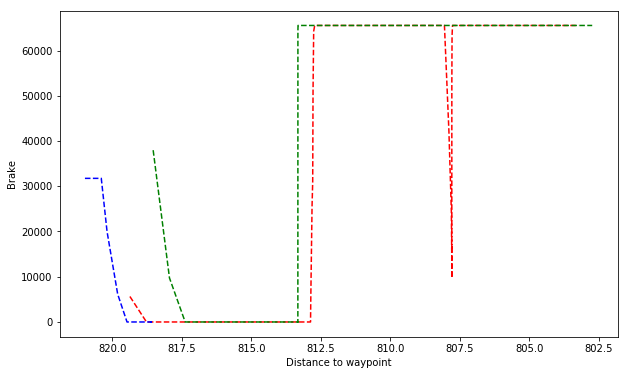

Another factor to have in mind, adding to the behavior of the driver, is the reaction of this one. We can see differents reactions time and also we can check the result of each one


In [13]:
plt.figure(figsize=(10, 6))
plt.plot(zoom2.currentDistance, zoom2.brake, 'r--', zoom3.currentDistance, zoom3.brake, 'b--', zoom1.currentDistance, zoom1.brake, 'g--')
plt.ylabel("Brake")
plt.xlabel("Distance to waypoint")
plt.gca().invert_xaxis()
#plt.savefig('brake_distance_zoom.pdf')
plt.show()

print ("Another factor to have in mind, adding to the behavior of the driver, is the reaction of this one. We can see differents reactions time and also we can check the result of each one")

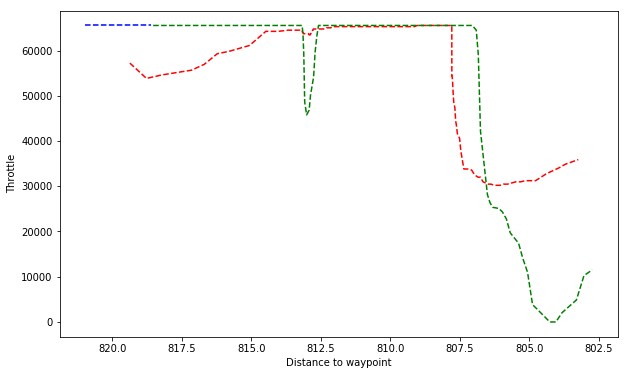

We just saw the brake before, and here we can see the throttle. This can be a factor to determine the behavior and also can give us information of how much aggresive is this driver.


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(zoom2.currentDistance, zoom2.throttle, 'r--', zoom3.currentDistance, zoom3.throttle, 'b--', zoom1.currentDistance, zoom1.throttle, 'g--')
plt.ylabel("Throttle")
plt.xlabel("Distance to waypoint")
plt.gca().invert_xaxis()
#plt.savefig('throttle_distance_zoom.pdf')
plt.show()

print ("We just saw the brake before, and here we can see the throttle. This can be a factor to determine the behavior and also can give us information of how much aggresive is this driver.")

DIDNT CROSS


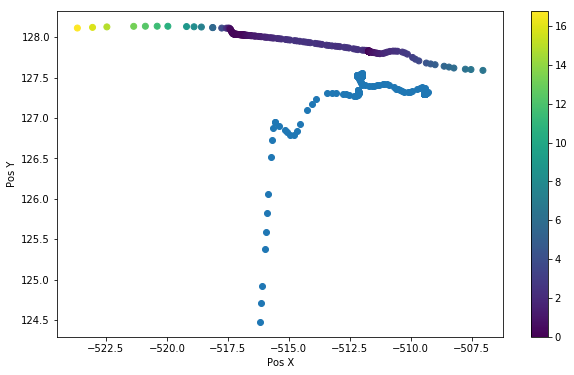

This is one particular case, that we saw in the experiment, and is produce when the driver is coming too fast and the pedestrian can't cross the street. So in this cases could be or not collision, but we are going to call this ANOMALIES. And we will discriminate from the normal hits or crashes. 


In [15]:
plt.figure(figsize=(10, 6))
dataZoom = zoom2
car = plt.scatter(dataZoom.Pos_X, dataZoom.Pos_Y, c=dataZoom.speed)
ped = plt.scatter(dataZoom.posPedX, dataZoom.posPedY, label="Ped")
plt.ylabel("Pos Y")
plt.xlabel("Pos X")
#plt.legend(ped, "Pos Ped")
#print dataZoom.iloc[0][10]
#print dataZoom.iloc[0][11]
#print dataZoom.iloc[-1][10]
#print dataZoom.iloc[-1][11]
#print dataZoom.iloc[0][3]
#print dataZoom.iloc[0][4]
#print dataZoom.iloc[-1][3]
#print dataZoom.iloc[-1][4]
puntoMedio = ((dataZoom.iloc[-1][3] + dataZoom.iloc[0][3])/2, (dataZoom.iloc[-1][4] + dataZoom.iloc[0][4])/2)
puntoMedio = (dataZoom.iloc[0][3], dataZoom.iloc[0][4])
#print dataZoom.iloc[-1][3]
#print dataZoom.iloc[-1][4]
if (dataZoom.iloc[0][10] > dataZoom.iloc[-1][10]):
    maxX = dataZoom.iloc[0][10]
    minX = dataZoom.iloc[-1][10]
else:
    minX = dataZoom.iloc[0][10]
    maxX = dataZoom.iloc[-1][10]
if (dataZoom.iloc[0][11] > dataZoom.iloc[-1][11]):
    maxY = dataZoom.iloc[0][11]
    minY = dataZoom.iloc[-1][11]
else:
    minY = dataZoom.iloc[0][11]
    maxY = dataZoom.iloc[-1][11]
#print maxY, minY, puntoMedio[1] 
if (minX <= puntoMedio[0] <= maxX or minY <= puntoMedio[1] <= maxY):
    print ("CROSSED")
else:
    print ("DIDNT CROSS")
#print dataZoom.iloc[-1][0] - dataZoom.iloc[0][0]
plt.colorbar(car)
#plt.savefig('positions_speed.pdf')
plt.show()

print ("This is one particular case, that we saw in the experiment, and is produce when the driver is coming too fast and the pedestrian can't cross the street. So in this cases could be or not collision, but we are going to call this ANOMALIES. And we will discriminate from the normal hits or crashes. ")

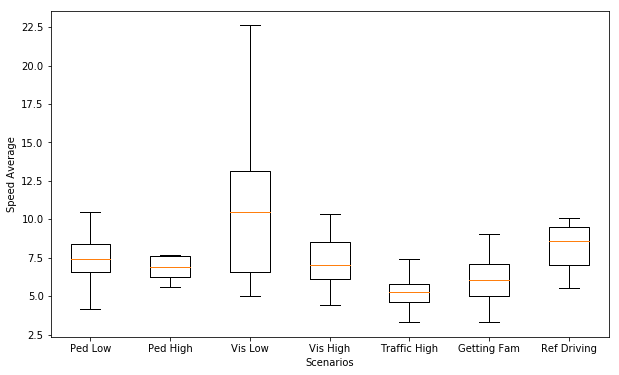

Here we can see the speed average in each scenario. After classified the drivers, we can see how did they change during the different scenarios.


In [16]:
# don't show outlier points
#speedAverageScenario
labels = ["Ped Low","Ped High","Vis Low","Vis High","Traffic High","Getting Fam","Ref Driving"]
scenarios = [1,2,3,4,6,7,8]
#speedAverageScenario[speedAverageScenario.scenario == 1]
speedAverageScenario = (dfGTA.groupby(['session_id', 'scenario'], as_index=False)['speed'].mean())
datos = []
for scenario in scenarios:
    datos.append(speedAverageScenario[speedAverageScenario.scenario == scenario]['speed'])


#data = np.concatenate((speedAverageScenario['scenario'], speedAverageScenario['speed']), 0)
#plt.boxplot(data, 0, '')
plt.figure(figsize=(10, 6))
plt.boxplot(datos,0, '')
plt.ylabel("Speed Average")
plt.xlabel("Scenarios")
plt.xticks([1,2,3,4,5,6,7], labels)
#plt.savefig('speedAverageScenariosBoxPlot.pdf')
plt.show()

print ("Here we can see the speed average in each scenario. After classified the drivers, we can see how did they change during the different scenarios.")

In [17]:
#speedAverageScenario
rateHit = [10.0/(24*4), 20.0/(24*12) ,12.0/(24*6) ,10.0/(24*6), 0 ,15.0/(24*6)]
pedHitPerSession = {}
for pedHit in pedsHit:
    session, scenario, pedId = pedHit
    if (pedId == 16 or pedId == 17):
        continue
    if session in pedHitPerSession:
        if scenario in pedHitPerSession[session]:
            pedHitPerSession[session][scenario] += rateHit[int(scenario-1)]
        else:
            pedHitPerSession[session][scenario] = rateHit[int(scenario-1)]
    else:
        pedHitPerSession[session] = {}
        pedHitPerSession[session][scenario] = rateHit[int(scenario-1)]
        
#pedsHit
#pedHitPerSession

In [18]:
speedAverageScenario = (dfGTA.groupby(['session_id', 'scenario'], as_index=False)['speed'].mean())
speeds = []
speedsPerScenario = {}
pedRatePerScenario = {}
pedRates = []
scenariosSpeedPed = []
for fila in speedAverageScenario.iterrows():
    idfila, filacompleta = fila
    session = filacompleta[0]
    scenario = filacompleta[1]
    speed = filacompleta[2]
    speeds.append(speed)
    rate = pedHitPerSession.get(session, 0)
    if (rate != 0):
        rate = rate.get(scenario, 0)
    pedRates.append(rate)
    scenariosSpeedPed.append(scenario)
    if scenario in speedsPerScenario:
        lista = (speedsPerScenario[scenario])
        #print type(lista)
        lista.append(speed)
        speedsPerScenario[scenario] = lista
    else:
        speedsPerScenario[scenario] = [speed]
    if scenario in pedRatePerScenario:
        lista = pedRatePerScenario[scenario]
        lista.append(rate)
        pedRatePerScenario[scenario] = lista
    else:
        pedRatePerScenario[scenario] = [rate]
    #speedsPerScenario[scenario] = (speedsPerScenario.get(scenario, [])).append(speed)
    #pedRatePerScenario[scenario] = (pedRatePerScenario.get(scenario, [])).append(rate)
    


In [19]:
pedCross = dfGTA[(dfGTA.nextPedRunning == True) & (dfGTA.distancePed < 20)  & (dfGTA.scenario != 7) & (dfGTA.scenario != 8)]
firstPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
lastPedCross = pedCross.groupby(['session_id', 'scenario', 'pedId'], as_index=False).last()
lastPedCross


def pedCross(midPoint, PedPosIniX,PedPosIniY , PedPosFinX,PedPosFinY ):
    if (PedPosIniX > PedPosFinX):
        maxX = PedPosIniX
        minX = PedPosFinX
    else:
        minX = PedPosIniX
        maxX = PedPosFinX
    if (PedPosIniY > PedPosFinY):
        maxY = PedPosIniY
        minY = PedPosFinY
    else:
        minY = PedPosIniY
        maxY = PedPosFinY
    if (minX <= midPoint[0] <= maxX or minY <= midPoint[1] <= maxY):
        return True
    return False

pedInfo = []

for filaPedCross in firstPedCross.iterrows():
    session = filaPedCross[1][0]
    scenario = filaPedCross[1][1]
    pedId = filaPedCross[1][2]
    posx = filaPedCross[1][4]
    posy = filaPedCross[1][5]
    posPedIniX = filaPedCross[1][10]
    posPedIniY = filaPedCross[1][11]
    posPedFinX = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedX"]
    posPedFinY = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedY"]
    
    posPedFinX2 = posPedFinX.iloc[0]
    posPedFinY2 = posPedFinY.iloc[0]
    #print posPedFinX2, posPedFinY2
    pedHit = ((session, scenario, pedId) in pedsHit)
    pedCrossed = pedCross([posx, posy], posPedIniX, posPedIniY, posPedFinX2, posPedFinY2)
    tupla = (session,scenario,pedId,pedHit, pedCrossed)
    pedInfo.append(tupla)
    
#pedInfo
#tuplelist2dict = {a: rest for a, *rest in pedInfo}
#tuplelist2dict
#lastPedCross[(lastPedCross.session_id == 144) & (lastPedCross.pedId == 3)  & (lastPedCross.scenario == 1)]["Pos_X"]

In [20]:
i = 0
pedInfoRateCrossed = []
hitCrossPerSession = {}
while (i < len(pedInfo)):
    session = pedInfo[i][0]
    sessionAct = pedInfo[i][0]
    hitCrossPerSession[sessionAct] = {}
    while (sessionAct == session):
        scenario = pedInfo[i][1]
        scenarioAct = pedInfo[i][1]
        hitCrossPerSession[sessionAct][scenarioAct] = {}
        totalHits = 0
        totalCrossed = 0
        while (scenario == scenarioAct): 
            if (pedInfo[i][2] == 16 or pedInfo[i][2] == 17):
                i += 1
                continue
            hitCrossPerSession[sessionAct][scenarioAct][pedInfo[i][2]] = (pedInfo[i][3], pedInfo[i][4])
            if (pedInfo[i][3]):
                totalHits += 1
            if (pedInfo[i][4]):
                totalCrossed += 1
            i += 1
            if (i >= len(pedInfo)):
                break
            scenarioAct = pedInfo[i][1]
        if (totalCrossed != 0):
            pedInfoRateCrossed.append((session, scenario, float(totalHits)/totalCrossed))
        if (i >= len(pedInfo)):
                break
        sessionAct = pedInfo[i][0]
pedInfoRateCrossedPerScenario = [[], [], [], [], [], [], []]
pedInfoSpeedCrossedPerScenario = [[], [], [], [], [], [], []]

for rates in pedInfoRateCrossed:
    pedInfoRateCrossedPerScenario[int(rates[1])].append(rates[2])

#print len(pedInfoRateCrossedPerScenario[1])
#print len(speedsPerScenario[1])
#speedsPerScenario
#hitCrossPerSession

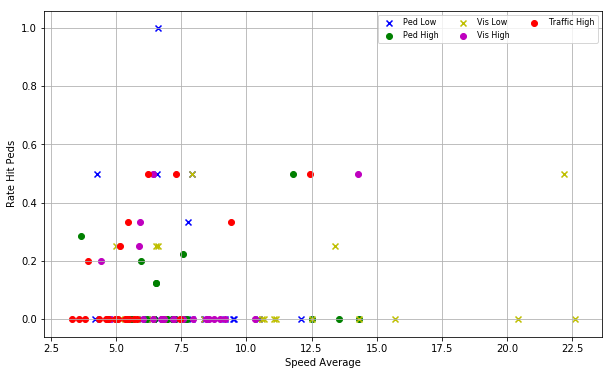

If we compare the average speed of each scenario with the pedestrians hit (rate in this case), we can see if there is a correlation between this two factors and also compare between each different variable of the scenarios.


In [21]:
plt.figure(figsize=(10, 6))
#plt.plot(speeds, pedRates, 'ro')
plt.xlabel("Speed Average")
plt.ylabel("Rate Hit Peds")
#for key, value in sorted(speedsPerScenario.iteritems()):
colors = ['b', 'g', 'y', 'm', 'r']
lo = plt.scatter(speedsPerScenario[1], pedInfoRateCrossedPerScenario[1], marker='x', color=colors[0])
ll = plt.scatter(speedsPerScenario[2], pedInfoRateCrossedPerScenario[2], marker='o', color=colors[1])
l  = plt.scatter(speedsPerScenario[3], pedInfoRateCrossedPerScenario[3], marker='x', color=colors[2])
a  = plt.scatter(speedsPerScenario[4], pedInfoRateCrossedPerScenario[4], marker='o', color=colors[3])
h  = plt.scatter(speedsPerScenario[6], pedInfoRateCrossedPerScenario[6], marker='o', color=colors[4])

plt.legend((lo, ll, l, a, h),
           ("Ped Low","Ped High","Vis Low","Vis High","Traffic High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)
#plt.xticks(scenarios, labels)
#plt.savefig('speedAverageScenariosAndNewRateHitsWithoutDogs.pdf')
plt.show()

print ("If we compare the average speed of each scenario with the pedestrians hit (rate in this case), we can see if there is a correlation between this two factors and also compare between each different variable of the scenarios.")

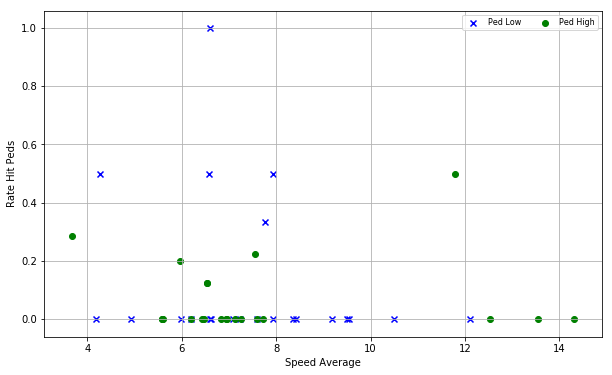

Here we can see between number of pedestrians high and low that there is a 'curve' if we don't see the points with rate 0. On the other hand, there are drivers with bad behavior (high speed) but with good results. Maybe with good reaction.


In [22]:
plt.figure(figsize=(10, 6))
#plt.plot(speeds, pedRates, 'ro')
plt.xlabel("Speed Average")
plt.ylabel("Rate Hit Peds")
#for key, value in sorted(speedsPerScenario.iteritems()):
colors = ['b', 'g', 'y', 'm', 'r']
lo = plt.scatter(speedsPerScenario[1], pedInfoRateCrossedPerScenario[1], marker='x', color=colors[0])
ll = plt.scatter(speedsPerScenario[2], pedInfoRateCrossedPerScenario[2], marker='o', color=colors[1])

plt.legend((lo, ll),
           ("Ped Low","Ped High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)
#plt.xticks(scenarios, labels)
#plt.savefig('speedAverageScenariosAndNewRateHitsWithoutDogsPeds.pdf')
plt.show()

print ("Here we can see between number of pedestrians high and low that there is a 'curve' if we don't see the points with rate 0. On the other hand, there are drivers with bad behavior (high speed) but with good results. Maybe with good reaction.")

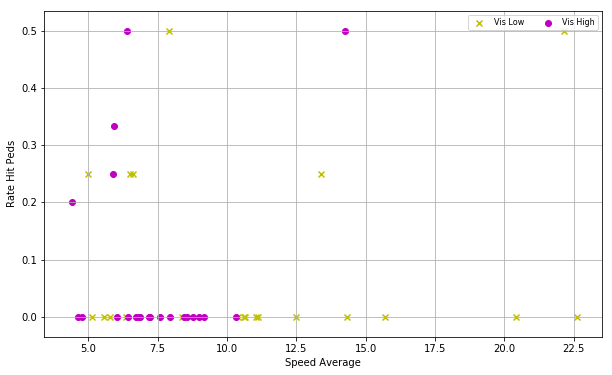

With visibility Low and High we can see again the same but with a curve more abrupte


In [23]:
plt.figure(figsize=(10, 6))
#plt.plot(speeds, pedRates, 'ro')
plt.xlabel("Speed Average")
plt.ylabel("Rate Hit Peds")
#for key, value in sorted(speedsPerScenario.iteritems()):
colors = ['b', 'g', 'y', 'm', 'r']

l  = plt.scatter(speedsPerScenario[3], pedInfoRateCrossedPerScenario[3], marker='x', color=colors[2])
a  = plt.scatter(speedsPerScenario[4], pedInfoRateCrossedPerScenario[4], marker='o', color=colors[3])


plt.legend((l, a),
           ("Vis Low","Vis High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)
#plt.xticks(scenarios, labels)
#plt.savefig('speedAverageScenariosAndNewRateHitsWithoutDogsVis.pdf')
plt.show()

print ("With visibility Low and High we can see again the same but with a curve more abrupte")

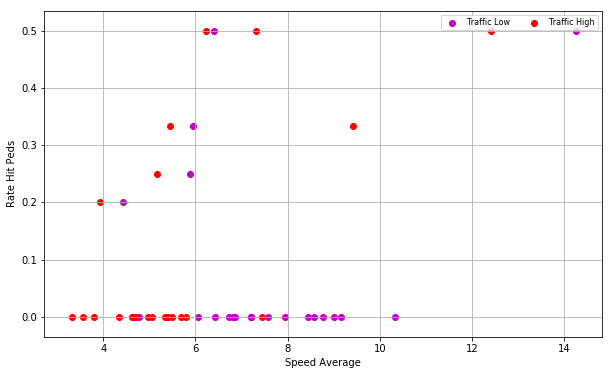

Here we can see that the ones who went fast with traffic high got bad results.


In [24]:
plt.figure(figsize=(10, 6))
#plt.plot(speeds, pedRates, 'ro')
plt.xlabel("Speed Average")
plt.ylabel("Rate Hit Peds")
#for key, value in sorted(speedsPerScenario.iteritems()):
colors = ['b', 'g', 'y', 'm', 'r']

a  = plt.scatter(speedsPerScenario[4], pedInfoRateCrossedPerScenario[4], marker='o', color=colors[3])
h  = plt.scatter(speedsPerScenario[6], pedInfoRateCrossedPerScenario[6], marker='o', color=colors[4])

plt.legend(( a, h),
           ("Traffic Low","Traffic High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)
#plt.xticks(scenarios, labels)
#plt.savefig('speedAverageScenariosAndNewRateHitsWithoutDogsTraffic.pdf')
plt.show()

print ("Here we can see that the ones who went fast with traffic high got bad results.")

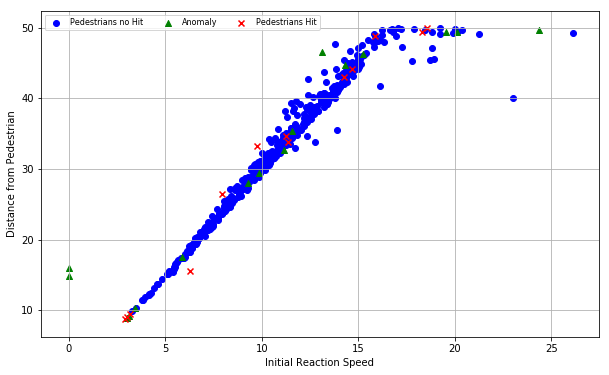

The pedestrians are triggered following a function that receives the speed and the acceleration of the vehicle. So we can see here that is a curve between the speed that have the car when the pedestrian is trigger and the distance between the car and the pedestrian. Saying this we can see here the 3 different posibilities of results. The normal one is the blue pedestrians NO HIT, then he have in green the ANOMALIES that we talked about and in red the pedestrians HIT. We can see that when the distance is too short is easy to hit the pedestrians.


In [25]:
dataGTARunning = df_joined[(df_joined.nextPedRunning == True) & (df_joined.scenario != 7) & (df_joined.scenario != 8)]
dataGTARunning = dataGTARunning.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()

dataSpeedHit = []
dataDistanceHit = []
throttleHit = []
dataSpeedNoHit = []
dataDistanceNoHit = []
throttleNoHit = []
dataSpeedAlmostHit = []
dataDistanceAlmostHit = []
throttleAlmostHit = []

for filaRun in dataGTARunning.iterrows():
    session = filaRun[1][0]
    scenario = filaRun[1][1]
    pedId = filaRun[1][2]
    speed = filaRun[1][9]
    throttle = filaRun[1][16]
    distancePed = filaRun[1][8]
    try:
        hitCrossed = hitCrossPerSession[session][scenario][pedId]
    except KeyError:
        continue
    if (pedId == 16 or pedId == 17):
        continue
    if (hitCrossed[0] == False and hitCrossed[1] == False):
        continue
    if (hitCrossed[0] == False and hitCrossed[1] == True):
        dataSpeedNoHit.append(speed)
        dataDistanceNoHit.append(distancePed)
        throttleNoHit.append(throttle)
        continue
    if (hitCrossed[0] == True and hitCrossed[1] == False):
        dataSpeedAlmostHit.append(speed)
        dataDistanceAlmostHit.append(distancePed)
        throttleAlmostHit.append(throttle)
        continue
    if (hitCrossed[0] == True and hitCrossed[1] == True):
        dataSpeedHit.append(speed)
        dataDistanceHit.append(distancePed)
        throttleHit.append(throttle)
        continue

        


plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed")
plt.ylabel("Distance from Pedestrian")
colors = ['b', 'g', 'y', 'm', 'r']

noHits = plt.scatter(dataSpeedNoHit, dataDistanceNoHit, marker='o', c='b')
Almosthits = plt.scatter(dataSpeedAlmostHit, dataDistanceAlmostHit, marker='^', c='g')
hits = plt.scatter(dataSpeedHit, dataDistanceHit, marker='x', c='r')
 
#'^'


plt.legend(( noHits, Almosthits,  hits),
           ("Pedestrians no Hit", "Anomaly" ,"Pedestrians Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)

#plt.colorbar(noHits)

#plt.colorbar(hits)
#plt.xticks(scenarios, labels)
#plt.savefig('InitialSpeedDistanceFromPedNewRateWithoutDogs.pdf')
plt.show()

print ("The pedestrians are triggered following a function that receives the speed and the acceleration of the vehicle. So we can see here that is a curve between the speed that have the car when the pedestrian is trigger and the distance between the car and the pedestrian. Saying this we can see here the 3 different posibilities of results. The normal one is the blue pedestrians NO HIT, then he have in green the ANOMALIES that we talked about and in red the pedestrians HIT. We can see that when the distance is too short is easy to hit the pedestrians.")

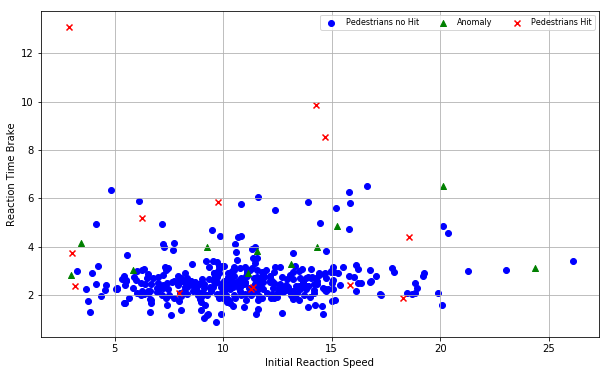

Continue with the reactions. Here we have the initial speed as well at the moment of trigger the pedestrian, and the seconds until the driver pressed the brake. We can see that the mayority of good cases (pedestrians No hit), are between 1 and 3 seconds of reaction and 5 to 15 the initial speed. We can find the mayority of ANOMALIES and HIT outside of this zone, altought there are some exceptions as we can see.


In [52]:
df_joined['brakeDIff'] = df_joined['brake'].diff()
startReactionBrake = df_joined[(df_joined.nextPedRunning == True) & (df_joined.brakeDIff >= 0)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]
finishReactionBrake = df_joined[(df_joined.nextPedRunning == True) & (df_joined.brakeDIff > 1000)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]
firstPedCross = startReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
lastPedCross = finishReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
#lastPedCross

dataSpeedHit = []
dataReactionBHit = []
throttleHit = []
dataSpeedNoHit = []
dataReactionBNoHit = []
throttleNoHit = []
dataSpeedAlmostHit = []
dataReactionBAlmostHit = []
throttleAlmostHit = []
dataDistanceHit = []
dataDistanceNoHit = []
dataDistanceAlmostHit = []

pedInfoReactBreak = []

reactionPerScenario = [[],[],[],[],[],[],[],[],[]]

for filaPedCross in firstPedCross.iterrows():
    session = filaPedCross[1][0]
    scenario = filaPedCross[1][1]
    pedId = filaPedCross[1][2]
    #posx = filaPedCross[1][4]
    #posy = filaPedCross[1][13]
    #print (filaPedCross[1])
    distancePed = filaPedCross[1][8]
    #print (distancePed)
    timeIni = filaPedCross[1][13]
    speed = filaPedCross[1][9]
    throttle = filaPedCross[1][16]
    timeFin = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]
    #posPedFinY = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedY"]
    #print (timeIni)
    if ( not timeFin.empty):
        #print (timeFin.iloc[0][13])
        #print (timeFin)
        reactionBrake = timeFin.iloc[0][13] - timeIni
        #print (reactionBrake)
        #print (reactionBrake.total_seconds())
        #print (float(reactionBrake.total_seconds()))
        reactionBrake = float(reactionBrake.total_seconds())
        #numero = int(reactionBrake.total_seconds()*1000000)
        #tupla = (session,scenario,pedId,numero, speed)
        #pedInfoReactBreak.append(tupla)
        if (reactionBrake > 50):
            continue
        lista = reactionPerScenario[int(scenario)]
        lista.append(reactionBrake)
        try:
            hitCrossed = hitCrossPerSession[session][scenario][pedId]
        except KeyError:
            continue
        if (pedId == 16 or pedId == 17):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == False):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == True):
            dataSpeedNoHit.append(speed)
            dataReactionBNoHit.append(reactionBrake)
            throttleNoHit.append(session)
            dataDistanceNoHit.append(distancePed)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == False):
            dataSpeedAlmostHit.append(speed)
            dataReactionBAlmostHit.append(reactionBrake)
            throttleAlmostHit.append(session)
            dataDistanceAlmostHit.append(distancePed)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == True):
            dataSpeedHit.append(speed)
            dataReactionBHit.append(reactionBrake)
            throttleHit.append(session)
            dataDistanceHit.append(distancePed)
            continue
    #posPedFinX2 = posPedFinX.iloc[0]
    #posPedFinY2 = posPedFinY.iloc[0]
    
    #print posPedFinX2, posPedFinY2
    #pedHit = ((session, scenario, pedId) in pedsHit)
    #pedCrossed = pedCross([posx, posy], posPedIniX, posPedIniY, posPedFinX2, posPedFinY2)
    #tupla = (session,scenario,pedId,pedHit, pedCrossed)
    #pedInfo.append(tupla)
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed")
plt.ylabel("Reaction Time Brake")
colors = ['b', 'g', 'y', 'm', 'r']

noHits = plt.scatter(dataSpeedNoHit, dataReactionBNoHit, marker='o', c='b')
Almosthits = plt.scatter(dataSpeedAlmostHit, dataReactionBAlmostHit, marker='^', c='g')
hits = plt.scatter(dataSpeedHit, dataReactionBHit, marker='x', c='r')
 
#'^'


plt.legend(( noHits, Almosthits,  hits),
           ("Pedestrians no Hit", "Anomaly" ,"Pedestrians Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)

#plt.colorbar(noHits)

#plt.colorbar(hits)
#plt.xticks(scenarios, labels)
#plt.savefig('InitialSpeedAndReactionBrakeNewRateWithoutDogs.pdf')
plt.show()

print ("Continue with the reactions. Here we have the initial speed as well at the moment of trigger the pedestrian, and the seconds until the driver pressed the brake. We can see that the mayority of good cases (pedestrians No hit), are between 1 and 3 seconds of reaction and 5 to 15 the initial speed. We can find the mayority of ANOMALIES and HIT outside of this zone, altought there are some exceptions as we can see.")

In [ ]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Distance")
plt.ylabel("Reaction Time Brake")
colors = ['b', 'g', 'y', 'm', 'r']

noHits = plt.scatter(dataDistanceNoHit, dataReactionBNoHit, marker='o', c='b')
Almosthits = plt.scatter(dataDistanceAlmostHit, dataReactionBAlmostHit, marker='^', c='g')
hits = plt.scatter(dataDistanceHit, dataReactionBHit, marker='x', c='r')
 
#'^'


plt.legend(( noHits, Almosthits,  hits),
           ("Pedestrians no Hit", "Anomaly" ,"Pedestrians Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)

#plt.colorbar(noHits)

#plt.colorbar(hits)
#plt.xticks(scenarios, labels)
plt.savefig('InitialDistanceAndReactionBrakeNewRateWithoutDogs.pdf')
plt.show()

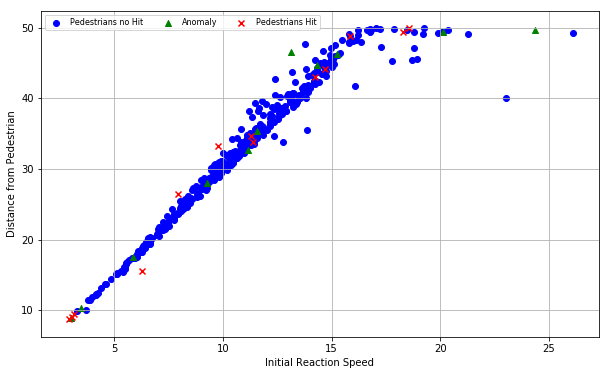

In [54]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed")
plt.ylabel("Distance from Pedestrian")
colors = ['b', 'g', 'y', 'm', 'r']

noHits = plt.scatter(dataSpeedNoHit, dataDistanceNoHit, marker='o', c='b')
Almosthits = plt.scatter(dataSpeedAlmostHit, dataDistanceAlmostHit, marker='^', c='g')
hits = plt.scatter(dataSpeedHit, dataDistanceHit, marker='x', c='r')
 
#'^'


plt.legend(( noHits, Almosthits,  hits),
           ("Pedestrians no Hit", "Anomaly" ,"Pedestrians Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)

#plt.colorbar(noHits)

#plt.colorbar(hits)
#plt.xticks(scenarios, labels)
#plt.savefig('InitialSpeedDistanceFromPedNewRateWithoutDogs.pdf')
plt.show()

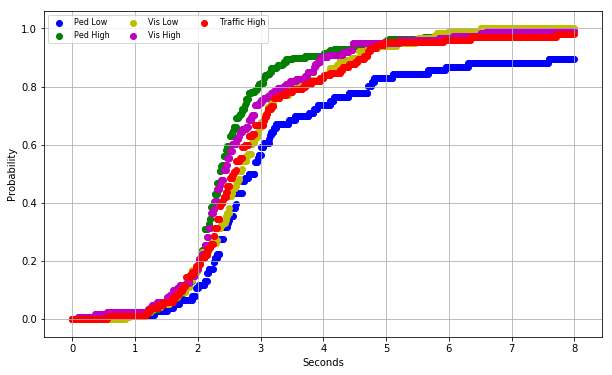

Thinking the reaction time as a random variable, we can find the probability function. If we collect all the reactions and we separate each scenario, we can see if there are differences between. In this case we have all of them and we can see as in the last plot that the reactions are mostly between 1 and 3 seconds. But also here we can see that there are some differences between every scenario.  


In [27]:
#reactions =  dataReactionBNoHit + dataReactionBAlmostHit + dataReactionBHit
reactions =  reactionPerScenario[1]
def distProb(x):
    total = len(reactions)
    cant = 0
    for elem in reactions:
        if (x >= elem):
            cant += 1
    prob = cant/total
    return prob

x = np.arange(0, 8, 0.01)
#np.apply_along_axis(distProb, 0, x)
f = np.vectorize(distProb, otypes=[np.float])
distribution = f(x)

plt.figure(figsize=(10, 6))
plt.ylabel("Probability")
plt.xlabel("Seconds")


colors = ['b', 'g', 'y', 'm', 'r']
reactions =  reactionPerScenario[1]
DistrScenario1 = f(x)
reactions =  reactionPerScenario[2]
DistrScenario2 = f(x)
reactions =  reactionPerScenario[3]
DistrScenario3 = f(x)
reactions =  reactionPerScenario[4]
DistrScenario4 = f(x)
reactions =  reactionPerScenario[6]
DistrScenario6 = f(x)
lo = plt.scatter(x, DistrScenario1, marker='o', color=colors[0])
ll = plt.scatter(x, DistrScenario2, marker='o', color=colors[1])
l  = plt.scatter(x, DistrScenario3, marker='o', color=colors[2])
a  = plt.scatter(x, DistrScenario4, marker='o', color=colors[3])
h  = plt.scatter(x, DistrScenario6, marker='o', color=colors[4])

plt.legend((lo, ll, l, a, h),
           ("Ped Low","Ped High","Vis Low","Vis High","Traffic High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
#noHits = plt.scatter(x, distribution, marker='o', c='b')
 
plt.grid(True)

#plt.savefig('DistributionScenarios2.pdf')
plt.show()

print ("Thinking the reaction time as a random variable, we can find the probability function. If we collect all the reactions and we separate each scenario, we can see if there are differences between. In this case we have all of them and we can see as in the last plot that the reactions are mostly between 1 and 3 seconds. But also here we can see that there are some differences between every scenario.  ")

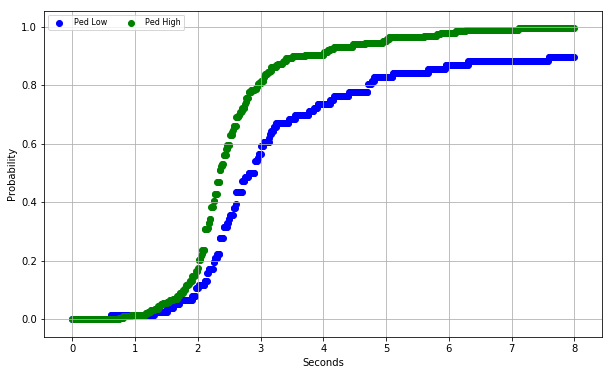

Between the Pedestrian Low and Pedestrian High scenario perhaps is the most surprising. There is a big difference, and this can be explained because in the first scenario the driver have more time to distract himself (cognitive distraction), and in the second the frequency of pedestrians is high so the driver is more attent.


In [28]:
plt.figure(figsize=(10, 6))
plt.ylabel("Probability")
plt.xlabel("Seconds")


colors = ['b', 'g', 'y', 'm', 'r']
reactions =  reactionPerScenario[1]
DistrScenario1 = f(x)
reactions =  reactionPerScenario[2]
DistrScenario2 = f(x)
reactions =  reactionPerScenario[3]
DistrScenario3 = f(x)
reactions =  reactionPerScenario[4]
DistrScenario4 = f(x)
reactions =  reactionPerScenario[6]
DistrScenario6 = f(x)
lo = plt.scatter(x, DistrScenario1, marker='o', color=colors[0])
ll = plt.scatter(x, DistrScenario2, marker='o', color=colors[1])

plt.legend((lo, ll),
           ("Ped Low","Ped High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
#noHits = plt.scatter(x, distribution, marker='o', c='b')
 
plt.grid(True)

plt.savefig('DistributionScenariosPedLowHigh.pdf')
plt.show()


print ("Between the Pedestrian Low and Pedestrian High scenario perhaps is the most surprising. There is a big difference, and this can be explained because in the first scenario the driver have more time to distract himself (cognitive distraction), and in the second the frequency of pedestrians is high so the driver is more attent.")

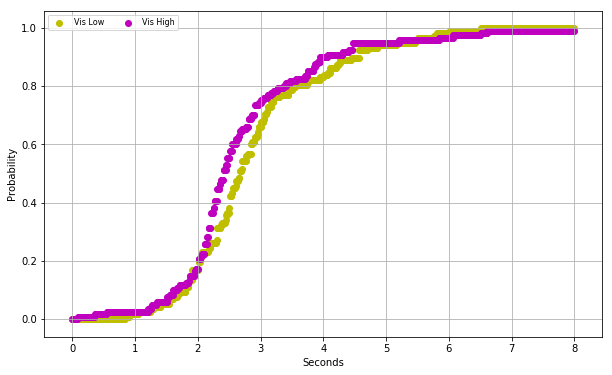

Between visibility low and high is expected to have more difficulties with the low visibility, and this is what happened but not really with so much difference.


In [29]:

plt.figure(figsize=(10, 6))
plt.ylabel("Probability")
plt.xlabel("Seconds")


colors = ['b', 'g', 'y', 'm', 'r']
l  = plt.scatter(x, DistrScenario3, marker='o', color=colors[2])
a  = plt.scatter(x, DistrScenario4, marker='o', color=colors[3])

plt.legend(( l, a),
           ("Vis Low","Vis High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
#noHits = plt.scatter(x, distribution, marker='o', c='b')
 
plt.grid(True)

plt.savefig('DistributionScenariosVisLowHigh.pdf')
plt.show()

print ("Between visibility low and high is expected to have more difficulties with the low visibility, and this is what happened but not really with so much difference.")

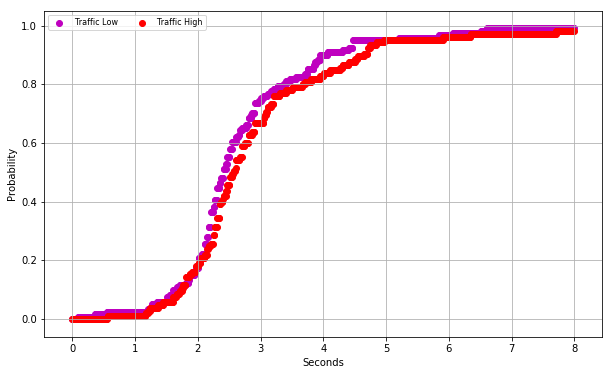

Finally between traffic high and Low there is a small difference that says that people react better when there is traffic low. This can be also explanied saying that sometimes when is traffic high you drive slow but also could have less visibility with a lot of cars in front.


In [30]:

plt.figure(figsize=(10, 6))
plt.ylabel("Probability")
plt.xlabel("Seconds")


colors = ['b', 'g', 'y', 'm', 'r']
a  = plt.scatter(x, DistrScenario4, marker='o', color=colors[3])
h  = plt.scatter(x, DistrScenario6, marker='o', color=colors[4])

plt.legend((a, h),
           ("Traffic Low","Traffic High"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
#noHits = plt.scatter(x, distribution, marker='o', c='b')
 
plt.grid(True)

plt.savefig('DistributionScenariosTrafficLowHigh.pdf')
plt.show()

print ("Finally between traffic high and Low there is a small difference that says that people react better when there is traffic low. This can be also explanied saying that sometimes when is traffic high you drive slow but also could have less visibility with a lot of cars in front.")

In [31]:
hitsPerPed = {}
for info in pedInfo:
    anomNew = 0
    hitNew = 0
    totalNew = 0
    if (info[4] == True):
        totalNew += 1
        if (info[3] == True):
            hitNew += 1
    else:
        if (info[3] == True):
            anomNew += 1
    
    if info[2] in hitsPerPed:
        anom, hit, total = hitsPerPed[(info[2])]
        hitsPerPed[(info[2])] = (anom + anomNew, hit + hitNew, total + totalNew)
    else:
        hitsPerPed[(info[2])] = (anomNew, hitNew, totalNew)
        

hitsPerPed.pop(16, None)
hitsPerPed.pop(17, None)
#hitsPerPed
lists = sorted(hitsPerPed.items()) # sorted by key, return a list of tuples
#print (lists)
x, y = zip(*lists) # unpack a list of pairs into two tuples
anom, hit, total = zip(*y) # unpack a list of pairs into two tuples
print (anom)
print (total[3])
i=0
anomRate = []
hitRate = []
for tot in total:
    anomRate.append( anom[i]/tot)
    hitRate.append(  hit[i]/tot )
    i += 1
    


(5, 2, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 4)
14


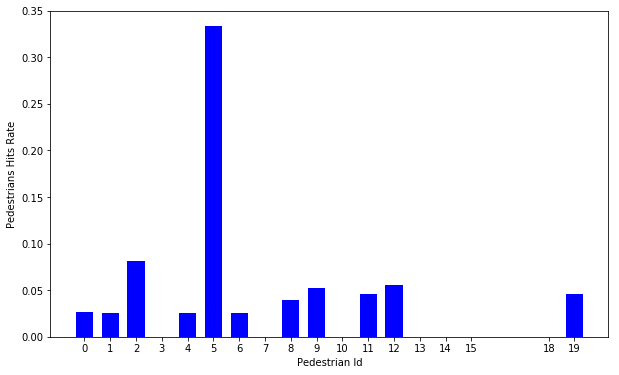

In [32]:
plt.figure(figsize=(10, 6))
plt.ylabel("Pedestrians Hits Rate")
plt.xlabel("Pedestrian Id")
plt.xticks(list(range(0,16)) + [18,19], list(range(0,16))  + [18,19])
plt.bar(list(range(0,16)) + [18,19], hitRate ,1/1.5, color="blue")
#plt.savefig('PedestriansHitsNewRateUpdateWithoutDogs.pdf')
plt.show()

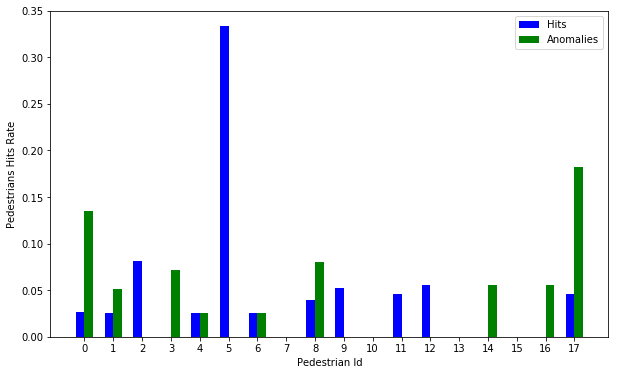

In [33]:
def add100(x):
    return x+100
 

x = np.arange(18)
plt.figure(figsize=(10, 6))
plt.ylabel("Pedestrians Hits Rate")
plt.xlabel("Pedestrian Id")
#x = list(range(0,16)) + [18,19]
#map(add100, x)
#print (x)
#plt.xticks(list(range(0,16)) + [18,19], list(range(0,16))  + [18,19])
ax = plt.subplot(111)
#ax.set_xticklabels(list(range(0,16)) + [18,19])
w = 0.3
ax.set_xticks(x + w / 2)
ax.set_xticklabels(x)
ax.bar(x, hitRate, width=w,color='b',align='center')
ax.bar(x + w, anomRate ,width=w,color='g',align='center')
#ax.autoscale(tight=True)
#ax.xaxis_date()
#print (anomRate)
ax.legend(('Hits', 'Anomalies'))
#print (hitRate)
#plt.savefig('PedestriansHitsNewRateUpdateWithAnomaliesWithoutDogs.pdf')
plt.show()

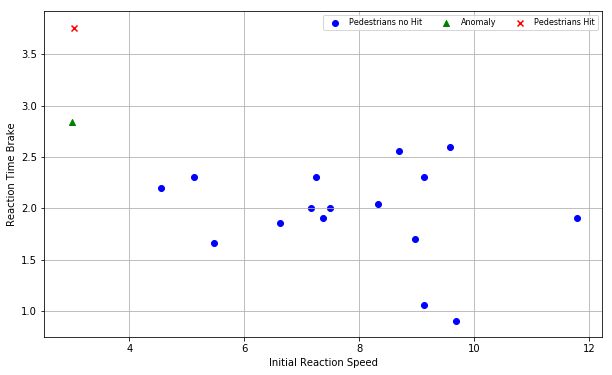

In [34]:
dataSpeedHit0 = []
dataReactionBHit0 = []
throttleHit0 = []
dataSpeedNoHit0 = []
dataReactionBNoHit0 = []
throttleNoHit0 = []
dataSpeedAlmostHit0 = []
dataReactionBAlmostHit0 = []
throttleAlmostHit0 = []

pedInfoReactBreak0 = []

reactionPerScenario0 = [[],[],[],[],[],[],[],[],[]]

for filaPedCross in firstPedCross.iterrows():
    session = filaPedCross[1][0]
    scenario = filaPedCross[1][1]
    pedId = filaPedCross[1][2]
    #posx = filaPedCross[1][4]
    #posy = filaPedCross[1][13]
    #print (filaPedCross[1])
    timeIni = filaPedCross[1][13]
    speed = filaPedCross[1][9]
    throttle = filaPedCross[1][16]
    timeFin = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]
    #posPedFinY = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedY"]
    #print (timeIni)
    if ( not timeFin.empty):
        #print (timeFin.iloc[0][13])
        #print (timeFin)
        reactionBrake = timeFin.iloc[0][13] - timeIni
        #print (reactionBrake)
        #print (reactionBrake.total_seconds())
        #print (float(reactionBrake.total_seconds()))
        reactionBrake = float(reactionBrake.total_seconds())
        #numero = int(reactionBrake.total_seconds()*1000000)
        #tupla = (session,scenario,pedId,numero, speed)
        #pedInfoReactBreak.append(tupla)
        #if (reactionBrake > 50):
        #    continue
        lista = reactionPerScenario0[int(scenario)]
        lista.append(reactionBrake)
        try:
            hitCrossed = hitCrossPerSession[session][scenario][pedId]
        except KeyError:
            continue
        if (pedId != 0):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == False):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == True):
            dataSpeedNoHit0.append(speed)
            dataReactionBNoHit0.append(reactionBrake)
            throttleNoHit0.append(session)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == False):
            dataSpeedAlmostHit0.append(speed)
            dataReactionBAlmostHit0.append(reactionBrake)
            throttleAlmostHit0.append(session)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == True):
            dataSpeedHit0.append(speed)
            dataReactionBHit0.append(reactionBrake)
            throttleHit0.append(session)
            continue
    #posPedFinX2 = posPedFinX.iloc[0]
    #posPedFinY2 = posPedFinY.iloc[0]
    
    #print posPedFinX2, posPedFinY2
    #pedHit = ((session, scenario, pedId) in pedsHit)
    #pedCrossed = pedCross([posx, posy], posPedIniX, posPedIniY, posPedFinX2, posPedFinY2)
    #tupla = (session,scenario,pedId,pedHit, pedCrossed)
    #pedInfo.append(tupla)
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed")
plt.ylabel("Reaction Time Brake")
colors = ['b', 'g', 'y', 'm', 'r']

noHits = plt.scatter(dataSpeedNoHit0, dataReactionBNoHit0, marker='o', c='b')
Almosthits = plt.scatter(dataSpeedAlmostHit0, dataReactionBAlmostHit0, marker='^', c='g')
hits = plt.scatter(dataSpeedHit0, dataReactionBHit0, marker='x', c='r')
 
#'^'


plt.legend(( noHits, Almosthits,  hits),
           ("Pedestrians no Hit", "Anomaly" ,"Pedestrians Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)

#plt.colorbar(noHits)

#plt.colorbar(hits)
#plt.xticks(scenarios, labels)
#plt.savefig('InitialSpeedAndReactionBrakeNewRateWithoutDogs.pdf')
plt.show()


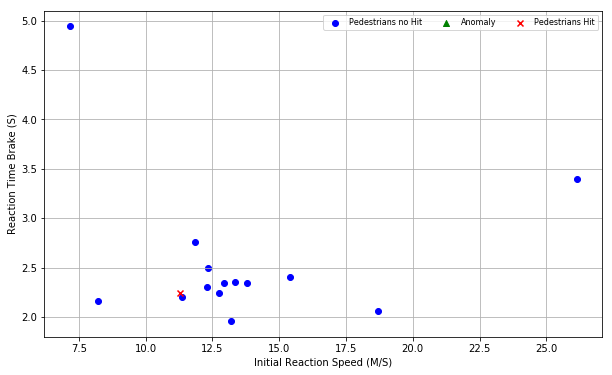

In [35]:
dataSpeedHit5 = []
dataReactionBHit5 = []
throttleHit5 = []
dataSpeedNoHit5 = []
dataReactionBNoHit5 = []
throttleNoHit5 = []
dataSpeedAlmostHit5 = []
dataReactionBAlmostHit5 = []
throttleAlmostHit5 = []

pedInfoReactBreak5 = []

reactionPerScenario5 = [[],[],[],[],[],[],[],[],[]]

for filaPedCross in firstPedCross.iterrows():
    session = filaPedCross[1][0]
    scenario = filaPedCross[1][1]
    pedId = filaPedCross[1][2]
    #posx = filaPedCross[1][4]
    #posy = filaPedCross[1][13]
    #print (filaPedCross[1])
    timeIni = filaPedCross[1][13]
    speed = filaPedCross[1][9]
    throttle = filaPedCross[1][16]
    timeFin = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]
    #posPedFinY = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedY"]
    #print (timeIni)
    if ( not timeFin.empty):
        #print (timeFin.iloc[0][13])
        #print (timeFin)
        reactionBrake = timeFin.iloc[0][13] - timeIni
        #print (reactionBrake)
        #print (reactionBrake.total_seconds())
        #print (float(reactionBrake.total_seconds()))
        reactionBrake = float(reactionBrake.total_seconds())
        #numero = int(reactionBrake.total_seconds()*1000000)
        #tupla = (session,scenario,pedId,numero, speed)
        #pedInfoReactBreak.append(tupla)
        if (reactionBrake > 15):
            continue
        lista = reactionPerScenario5[int(scenario)]
        lista.append(reactionBrake)
        try:
            hitCrossed = hitCrossPerSession[session][scenario][pedId]
        except KeyError:
            continue
        if (pedId != 12):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == False):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == True):
            dataSpeedNoHit5.append(speed)
            dataReactionBNoHit5.append(reactionBrake)
            throttleNoHit5.append(session)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == False):
            dataSpeedAlmostHit5.append(speed)
            dataReactionBAlmostHit5.append(reactionBrake)
            throttleAlmostHit5.append(session)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == True):
            dataSpeedHit5.append(speed)
            dataReactionBHit5.append(reactionBrake)
            throttleHit5.append(session)
            continue
    #posPedFinX2 = posPedFinX.iloc[0]
    #posPedFinY2 = posPedFinY.iloc[0]
    
    #print posPedFinX2, posPedFinY2
    #pedHit = ((session, scenario, pedId) in pedsHit)
    #pedCrossed = pedCross([posx, posy], posPedIniX, posPedIniY, posPedFinX2, posPedFinY2)
    #tupla = (session,scenario,pedId,pedHit, pedCrossed)
    #pedInfo.append(tupla)
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed (M/S)")
plt.ylabel("Reaction Time Brake (S)")
colors = ['b', 'g', 'y', 'm', 'r']

noHits = plt.scatter(dataSpeedNoHit5, dataReactionBNoHit5, marker='o', c='b')
Almosthits = plt.scatter(dataSpeedAlmostHit5, dataReactionBAlmostHit5, marker='^', c='g')
hits = plt.scatter(dataSpeedHit5, dataReactionBHit5, marker='x', c='r')
 
#'^'


plt.legend(( noHits, Almosthits,  hits),
           ("Pedestrians no Hit", "Anomaly" ,"Pedestrians Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)

#plt.colorbar(noHits)

#plt.colorbar(hits)
#plt.xticks(scenarios, labels)
#plt.savefig('InitialSpeedAndReactionBrakeNewRateWithoutDogs.pdf')
plt.show()


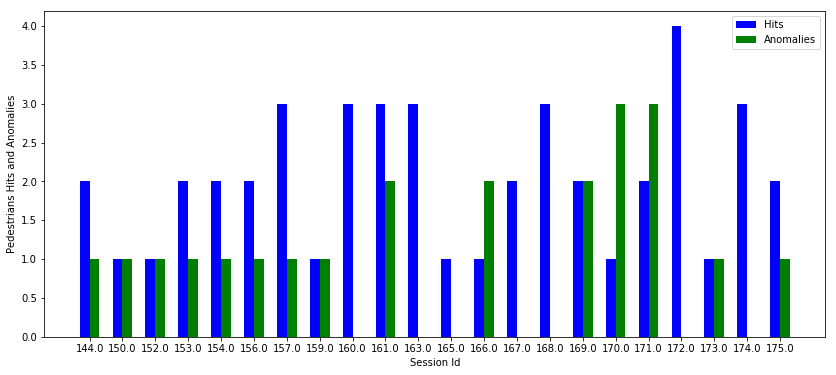

In [36]:
sessions = []
hitsSession = []
anomaliesSession = []
lastSession = 0
index = -1
for row in pedInfo:
    if (row[0] != lastSession):
        sessions.append(row[0])
        hitsSession.append(0)
        anomaliesSession.append(0)
        lastSession = row[0]
        index += 1
    if (row[3] == True and row[4] == False):
        anomaliesSession[index] += 1
        continue
    if (row[3] == True and row[4] == True):
        hitsSession[index] += 1
        continue
        
x = np.arange(22)
plt.figure(figsize=(14, 6))
plt.ylabel("Pedestrians Hits and Anomalies")
plt.xlabel("Session Id")
#x = list(range(0,16)) + [18,19]
#map(add100, x)
#print (x)
#plt.xticks(list(range(0,16)) + [18,19], list(range(0,16))  + [18,19])
ax = plt.subplot(111)
#ax.set_xticklabels(list(range(0,16)) + [18,19])
w = 0.3
ax.set_xticks(x + w / 2)
ax.set_xticklabels(sessions)
ax.bar(x, hitsSession, width=w,color='b',align='center')
ax.bar(x + w, anomaliesSession ,width=w,color='g',align='center')
#ax.autoscale(tight=True)
#ax.xaxis_date()
#print (anomRate)
ax.legend(('Hits', 'Anomalies'))
#print (hitRate)
#plt.savefig('SessionsHitsAndAnomalies.pdf')
plt.show()

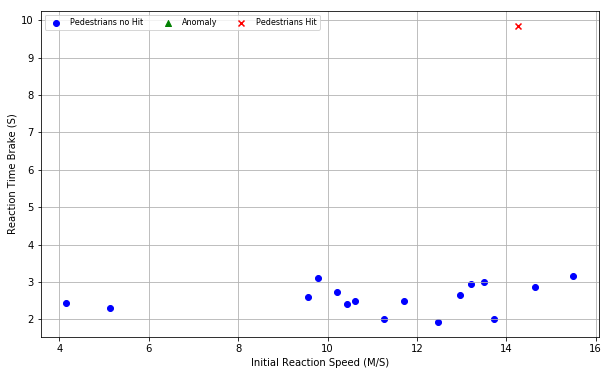

In [37]:
dataSpeedHit5 = []
dataReactionBHit5 = []
throttleHit5 = []
dataSpeedNoHit5 = []
dataReactionBNoHit5 = []
throttleNoHit5 = []
dataSpeedAlmostHit5 = []
dataReactionBAlmostHit5 = []
throttleAlmostHit5 = []

pedInfoReactBreak5 = []

reactionPerScenario5 = [[],[],[],[],[],[],[],[],[]]

for filaPedCross in firstPedCross.iterrows():
    session = filaPedCross[1][0]
    scenario = filaPedCross[1][1]
    pedId = filaPedCross[1][2]
    #posx = filaPedCross[1][4]
    #posy = filaPedCross[1][13]
    #print (filaPedCross[1])
    timeIni = filaPedCross[1][13]
    speed = filaPedCross[1][9]
    throttle = filaPedCross[1][16]
    timeFin = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]
    #posPedFinY = lastPedCross[(lastPedCross.session_id == session) & (lastPedCross.pedId == pedId)  & (lastPedCross.scenario == scenario)]["posPedY"]
    #print (timeIni)
    if ( not timeFin.empty):
        #print (timeFin.iloc[0][13])
        #print (timeFin)
        reactionBrake = timeFin.iloc[0][13] - timeIni
        #print (reactionBrake)
        #print (reactionBrake.total_seconds())
        #print (float(reactionBrake.total_seconds()))
        reactionBrake = float(reactionBrake.total_seconds())
        #numero = int(reactionBrake.total_seconds()*1000000)
        #tupla = (session,scenario,pedId,numero, speed)
        #pedInfoReactBreak.append(tupla)
        #if (reactionBrake > 15):
        #    continue
        lista = reactionPerScenario5[int(scenario)]
        lista.append(reactionBrake)
        try:
            hitCrossed = hitCrossPerSession[session][scenario][pedId]
        except KeyError:
            continue
        if (session != 172):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == False):
            continue
        if (hitCrossed[0] == False and hitCrossed[1] == True):
            dataSpeedNoHit5.append(speed)
            dataReactionBNoHit5.append(reactionBrake)
            throttleNoHit5.append(session)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == False):
            dataSpeedAlmostHit5.append(speed)
            dataReactionBAlmostHit5.append(reactionBrake)
            throttleAlmostHit5.append(session)
            continue
        if (hitCrossed[0] == True and hitCrossed[1] == True):
            dataSpeedHit5.append(speed)
            dataReactionBHit5.append(reactionBrake)
            throttleHit5.append(session)
            continue
    #posPedFinX2 = posPedFinX.iloc[0]
    #posPedFinY2 = posPedFinY.iloc[0]
    
    #print posPedFinX2, posPedFinY2
    #pedHit = ((session, scenario, pedId) in pedsHit)
    #pedCrossed = pedCross([posx, posy], posPedIniX, posPedIniY, posPedFinX2, posPedFinY2)
    #tupla = (session,scenario,pedId,pedHit, pedCrossed)
    #pedInfo.append(tupla)
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed (M/S)")
plt.ylabel("Reaction Time Brake (S)")
colors = ['b', 'g', 'y', 'm', 'r']

noHits = plt.scatter(dataSpeedNoHit5, dataReactionBNoHit5, marker='o', c='b')
Almosthits = plt.scatter(dataSpeedAlmostHit5, dataReactionBAlmostHit5, marker='^', c='g')
hits = plt.scatter(dataSpeedHit5, dataReactionBHit5, marker='x', c='r')
 
#'^'


plt.legend(( noHits, Almosthits,  hits),
           ("Pedestrians no Hit", "Anomaly" ,"Pedestrians Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
    
#plt.scatter(speeds,pedRates,c=scenariosSpeedPed, label=['Low Peds','High Peds',3,4,6,7,8])
#plt.legend(('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1,
#           loc='lower left',
#           ncol=3,
#           fontsize=8)
#plt.legend(('Low Peds', 'High Peds', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'), scatterpoints=1)
plt.grid(True)

#plt.colorbar(noHits)

#plt.colorbar(hits)
#plt.xticks(scenarios, labels)
#plt.savefig('InitialSpeedAndReactionBrakeNewRateWithoutDogs.pdf')
plt.show()


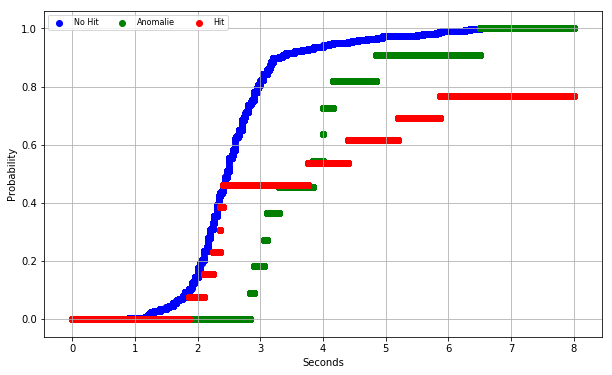

In [38]:
#reactions =  dataReactionBNoHit + dataReactionBAlmostHit + dataReactionBHit
reactions =  dataReactionBNoHit

x = np.arange(0, 8, 0.0001)
#np.apply_along_axis(distProb, 0, x)
f = np.vectorize(distProb, otypes=[np.float])
distribution = f(x)

plt.figure(figsize=(10, 6))
plt.ylabel("Probability")
plt.xlabel("Seconds")


colors = ['b', 'g', 'y', 'm', 'r']
reactions =  dataReactionBNoHit
DistrScenario1 = f(x)
reactions =  dataReactionBAlmostHit
DistrScenario2 = f(x)
reactions =  dataReactionBHit
DistrScenario3 = f(x)
lo = plt.scatter(x, DistrScenario1, marker='o', color=colors[0])
ll = plt.scatter(x, DistrScenario2, marker='o', color=colors[1])
l  = plt.scatter(x, DistrScenario3, marker='o', color=colors[4])

plt.legend((lo, ll, l),
           ("No Hit","Anomalie","Hit"),
           scatterpoints=1,
           ncol=3,
           fontsize=8)
#noHits = plt.scatter(x, distribution, marker='o', c='b')
 
plt.grid(True)

#plt.savefig('DistributionReactions.pdf')
plt.show()

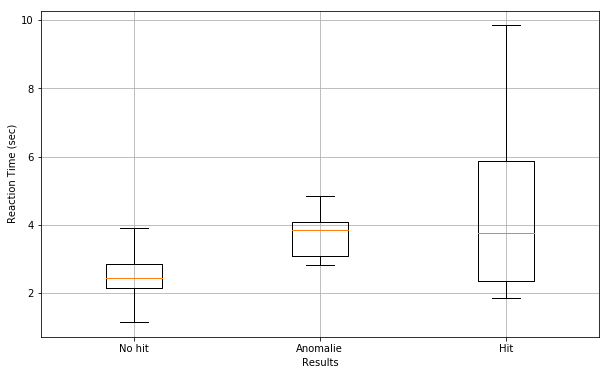

In [39]:
# don't show outlier points
#speedAverageScenario
labels = ["No hit","Anomalie","Hit"]
scenarios = [1,2,3,4,6,7,8]
#speedAverageScenario[speedAverageScenario.scenario == 1]

datos = []

datos.append(np.array(dataReactionBNoHit))
datos.append(np.array(dataReactionBAlmostHit))
datos.append(np.array(dataReactionBHit))


#data = np.concatenate((speedAverageScenario['scenario'], speedAverageScenario['speed']), 0)
#plt.boxplot(data, 0, '')
plt.figure(figsize=(10, 6))
plt.boxplot(datos,0, '')
plt.ylabel("Reaction Time (sec)")
plt.xlabel("Results")
plt.xticks([1,2,3], labels)
#plt.savefig('ResultsAndReactionTimeBoxPlot.pdf')
plt.grid(True)
plt.show()

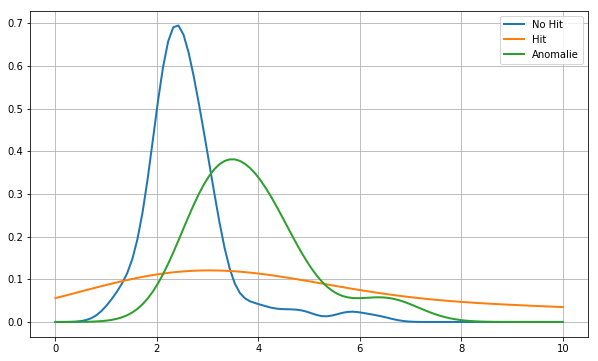

In [40]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace
plt.figure(figsize=(10, 6))
# create fake data
data = dataReactionBNoHit
# this create the kernel, given an array it will estimate the probability over that values
kde = gaussian_kde( data )
# these are the values over wich your kernel will be evaluated
dist_space = linspace( 0,10, 100 )

# create fake data
data2 = dataReactionBHit
# this create the kernel, given an array it will estimate the probability over that values
kde2 = gaussian_kde( data2 )
# these are the values over wich your kernel will be evaluated
dist_space2 = linspace(0, 10, 100 )
# create fake data
data3 = dataReactionBAlmostHit
# this create the kernel, given an array it will estimate the probability over that values
kde3 = gaussian_kde( data3 )

dist_space3 = linspace( min(data), max(data2), 100 )
# plot the results

plt.grid(True)
#plt.plot( dist_space3, kde(dist_space),dist_space3, kde(dist_space2), dist_space3, kde(dist_space3) )
plt.plot(dist_space,kde(dist_space),lw=2, label='No Hit')
plt.plot(dist_space,kde2(dist_space),lw=2, label='Hit')
plt.plot(dist_space,kde3(dist_space),lw=2, label='Anomalie')
plt.legend(loc='best')
#plt.savefig('ResultsAndReactionDensity.pdf')

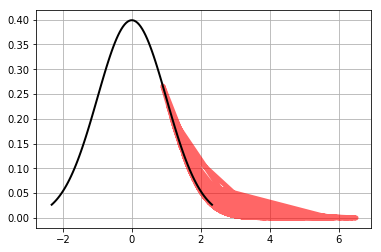

In [41]:
from scipy.stats import norm
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(1, 1)

x = np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100)
ax.plot(data, norm.pdf(data),'r-', lw=5, alpha=0.6, label='norm pdf')
rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

plt.grid(True)
plt.show()

Automatically created module for IPython interactive environment


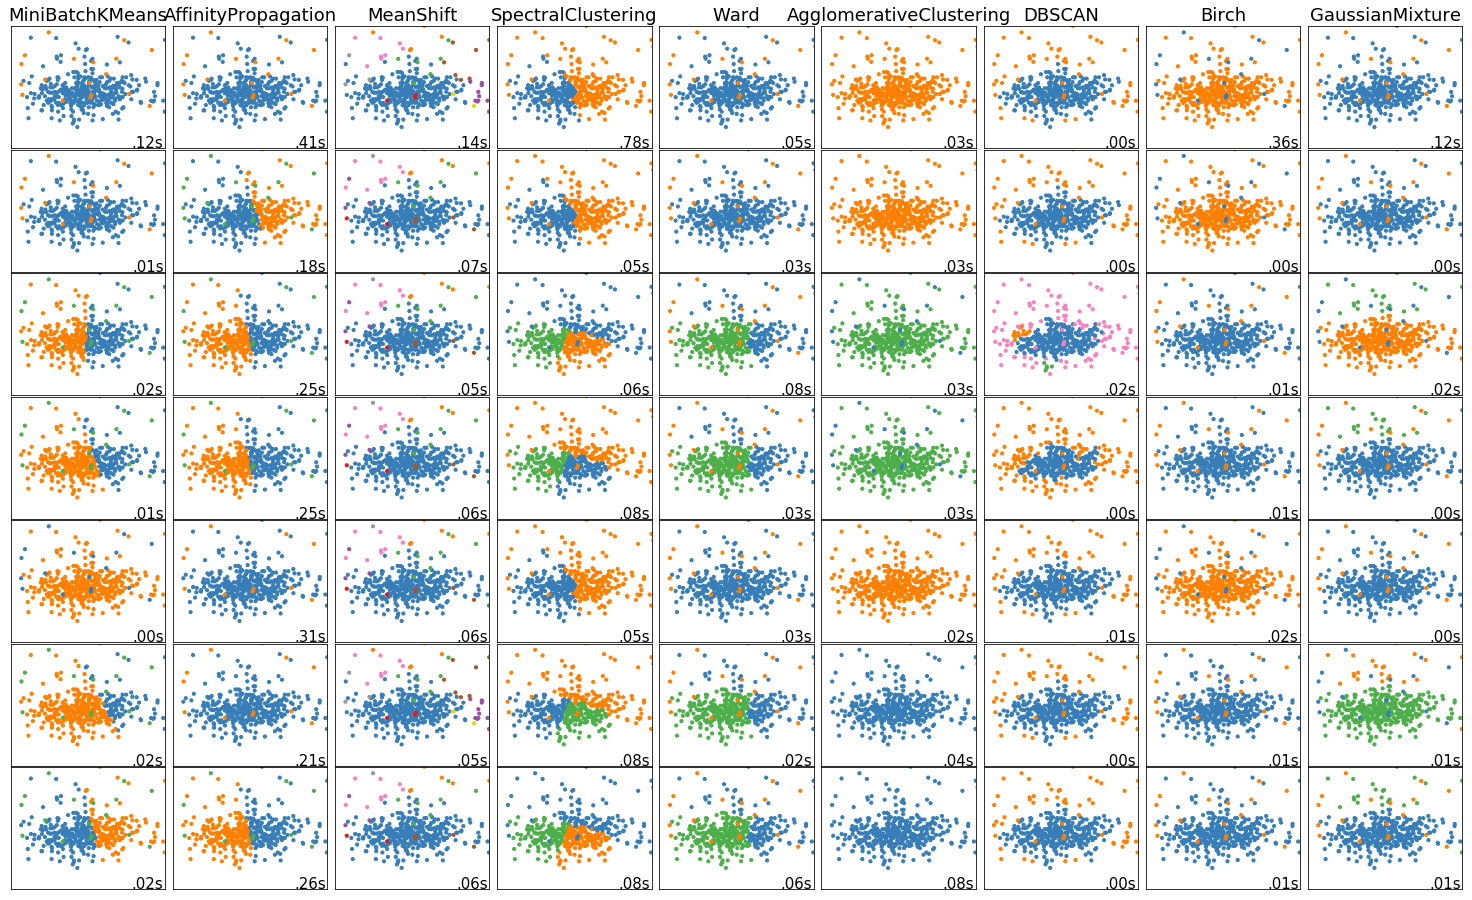

In [42]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

#My data set
"""speedTotal = dataSpeedNoHit + dataSpeedAlmostHit + dataSpeedHit
reactionTotal = dataReactionBNoHit + dataReactionBAlmostHit + dataReactionBHit
reactionSpeed = pd.DataFrame(
    {  'reaction': reactionTotal,
        'aspeed': speedTotal
    })
array = np.array(reactionSpeed)
label = [0]*len(dataReactionBNoHit) + [1]*len(dataReactionBAlmostHit) +[2]*len(dataReactionBHit)
Label = np.array(label)
reaction = array, Label"""
#My data set
speedTotal = dataSpeedNoHit + dataSpeedAlmostHit + dataSpeedHit
reactionTotal = dataReactionBNoHit + dataReactionBAlmostHit + dataReactionBHit
label = [0]*len(dataReactionBNoHit) + [1]*len(dataReactionBAlmostHit) +[2]*len(dataReactionBHit)
Label = np.array(label)
reactionSpeed = pd.DataFrame(
    {  'reaction': reactionTotal,
        'aspeed': speedTotal,
         'zhit': label
    })
array = np.array(reactionSpeed)

reaction = array, None
#noHits = plt.scatter(dataSpeedNoHit, dataReactionBNoHit, marker='o', c='b')
#Almosthits = plt.scatter(dataSpeedAlmostHit, dataReactionBAlmostHit, marker='^', c='g')
#hits = plt.scatter(dataSpeedHit, dataReactionBHit, marker='x', c='r')

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (reaction, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (reaction, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (reaction, {'eps': .18, 'n_neighbors': 2}),
    (reaction, {'eps': .15, 'n_neighbors': 2}),
    (reaction, {'quantile': .3,
                'eps': .3,
                'damping': .6,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 2}),
    (reaction, {'quantile': .2,
                'eps': .3,
                'damping': .9,
                'preference': -250,
                'n_neighbors': 10,
                'n_clusters': 3}),
    (reaction, {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

#plt.savefig('ClustersSpeedReaction.pdf')
plt.show()

In [43]:
y_pred

array([0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0,
       0, 0,

In [44]:
#My data set
speedTotal = dataSpeedNoHit + dataSpeedAlmostHit + dataSpeedHit
reactionTotal = dataReactionBNoHit + dataReactionBAlmostHit + dataReactionBHit
label = [0]*len(dataReactionBNoHit) + [1]*len(dataReactionBAlmostHit) +[2]*len(dataReactionBHit)
Label = np.array(label)
reactionSpeed = pd.DataFrame(
    {  'reaction': reactionTotal,
        'aspeed': speedTotal,
         'zhit': label
    })
array = np.array(reactionSpeed)

reaction = array, None

In [45]:
reaction

(array([[  7.75488043,   1.900057  ,   0.        ],
        [ 18.4610558 ,   2.10059   ,   0.        ],
        [ 10.1261988 ,   2.002328  ,   0.        ],
        ..., 
        [ 14.2546606 ,   9.845675  ,   2.        ],
        [  6.27697563,   5.200339  ,   2.        ],
        [  2.91306257,  13.094349  ,   2.        ]]), None)